<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/GNN%20Graph%20Attention%20Network%20PubMed%20article.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Attention Networks for PubMed article's dataset
> Chapter 2 of the [Graph Neural Network Course](https://github.com/mlabonne/Graph-Neural-Network-Course)

In [35]:
# We assume that PyTorch is already installed
import torch
torchversion = torch.__version__

# Numpy for matrices
import numpy as np
np.random.seed(0)

# Visualization
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd


import torch_geometric

In [ ]:

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 24.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.4 MB/s eta 0:00:00


# Dataset

PubMed. Это набор данных из 19 717 научных публикаций о диабете из базы данных PubMed из трёх категорий. Признаки узла — взвешенные по TF-IDF векторы слов из словаря на 500 уникальных слов.

In [142]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="Pubmed")

data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [143]:
data

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])

> data.x: Node feature matrix with shape [num_nodes, num_node_features]
>
> data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
>
> data.edge_index: Graph connectivity in COO format with shape [2, num_edges]
>
> data.y: Target to train against (may have arbitrary shape), e.g., node-level > targets of shape [num_nodes, *] or graph-level targets of shape [1, *]
>
> data.pos: Node position matrix with shape [num_nodes, num_dimensions]

In [144]:
from torch_geometric.utils import remove_isolated_nodes

isolated = (remove_isolated_nodes(data['edge_index'])[2] == False).sum(dim=0).item()
print(f'Number of isolated nodes = {isolated}')

Number of isolated nodes = 0


In [145]:
data_df = pd.DataFrame(data.x)
data_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
19712,0.000000,0.000000,0.007237,0.0,0.0,0.0,0.0,0.003601,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19713,0.026882,0.000000,0.008414,0.0,0.0,0.0,0.0,0.004186,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19714,0.000000,0.019427,0.007961,0.0,0.0,0.0,0.0,0.003961,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19715,0.107821,0.000000,0.000000,0.0,0.0,0.0,0.0,0.011194,0.047062,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19716,0.000000,0.026584,0.000000,0.0,0.0,0.0,0.0,0.005420,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
data_df = pd.DataFrame(data.y)
data_df.tail()
pd.unique(data_df[0])

array([1, 0, 2])

# Plot dataset

In [147]:
from torch_geometric.utils import to_networkx
G_full = to_networkx(data)

In [148]:
node_degree_dict=nx.degree(G_full)
#node_degree_dict

In [149]:
G=nx.subgraph(G_full,[x for x in G_full.nodes() if node_degree_dict[x]>15])

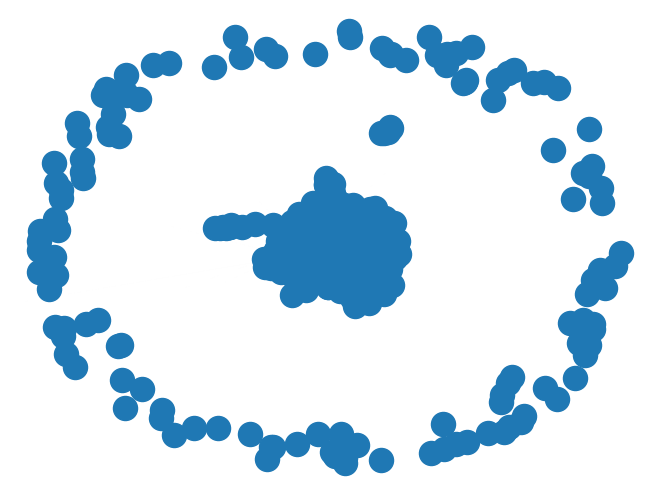

In [132]:
pos = nx.spring_layout(G)

plt.figure()
nx.draw(G, pos=pos)
plt.show()

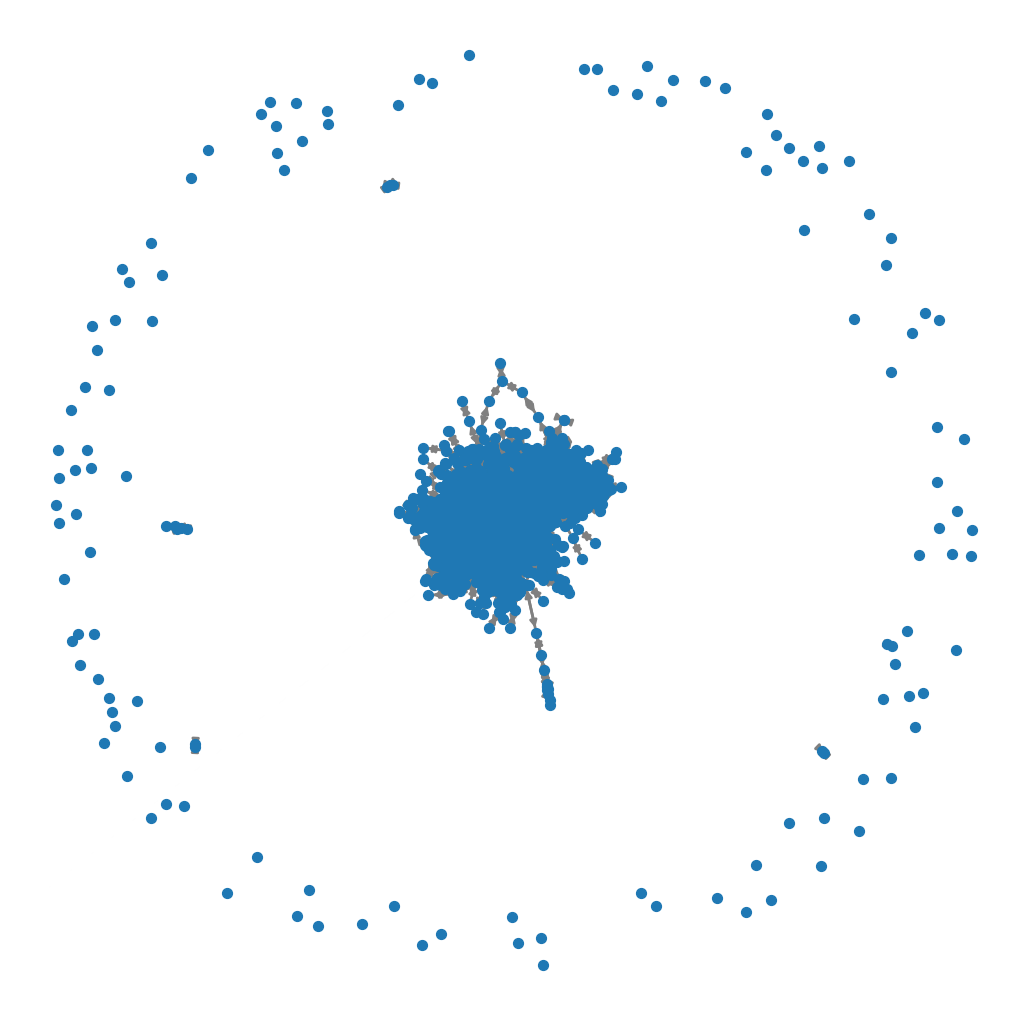

In [133]:
plt.figure(figsize=(13,13))

plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=False,
                node_size=50,
                #node_color=data.y,
                width=2,
                edge_color="grey"
                )
plt.show()

In [150]:
adj_matrix_df = nx.to_pandas_adjacency(G)
adj_matrix_df.head()

,8192,8193,16384,16387,8197,6,7,8198,9,16391,...,16361,16362,8175,16367,16370,16373,16378,16379,16380,16383
8192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [151]:
node_names = G.nodes
df = pd.DataFrame(node_names)
df[0]

,0
0,8192
1,8193
2,16384
3,16387
4,8197
...,...
3207,16373
3208,16378
3209,16379
3210,16380


In [137]:
data_df_y = pd.DataFrame(data.y)
data_df_y.tail()

label=list(data_df_y)

In [138]:
A = nx.to_pandas_adjacency(G)
A

,8192,8193,16384,16387,8197,6,7,8198,9,16391,...,16361,16362,8175,16367,16370,16373,16378,16379,16380,16383
8192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
#df = nx.to_pandas_edgelist(G, nodelist=["A", "C"], edge_key="ekey")
graph_df = nx.to_pandas_edgelist(G, nodelist=node_names, edge_key="ekey")
#df[["source", "target"]]
graph_df.head()

,source,target
0,16387,1119
1,16387,1205
2,16387,6075
3,16387,6149
4,16387,8024


In [162]:
from torch_geometric.utils import from_networkx
from_networkx(G)

Data(edge_index=[2, 29540], num_nodes=3212)

# Plot node degrees

<BarContainer object of 82 artists>

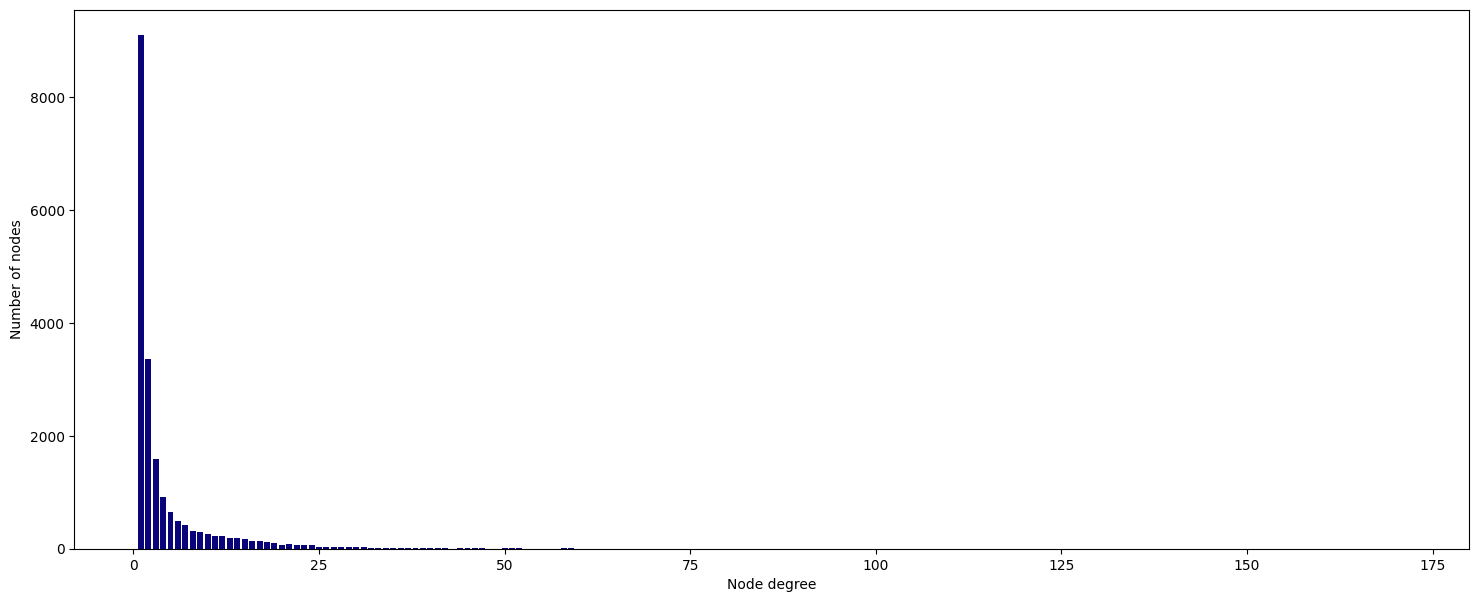

In [163]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

# Implement GAT vs. GCN

In [164]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)


class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 50

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

# Train GCN

In [165]:
%%time

# Create GCN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
train(gcn, data)

# Test
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(500, 16)
  (gcn2): GCNConv(16, 3)
)
Epoch   0 | Train Loss: 1.097 | Train Acc:  38.33% | Val Loss: 1.10 | Val Acc: 36.80%
Epoch  10 | Train Loss: 0.958 | Train Acc:  85.00% | Val Loss: 1.01 | Val Acc: 67.40%
Epoch  20 | Train Loss: 0.737 | Train Acc:  88.33% | Val Loss: 0.88 | Val Acc: 68.00%
Epoch  30 | Train Loss: 0.566 | Train Acc:  90.00% | Val Loss: 0.78 | Val Acc: 71.80%
Epoch  40 | Train Loss: 0.361 | Train Acc:  93.33% | Val Loss: 0.71 | Val Acc: 72.20%
Epoch  50 | Train Loss: 0.291 | Train Acc:  98.33% | Val Loss: 0.67 | Val Acc: 74.00%

GCN test accuracy: 77.70%

CPU times: user 4.41 s, sys: 4.06 s, total: 8.47 s
Wall time: 8.63 s


# Train GAT

In [166]:
%%time

# Create GAT model
gat = GAT(dataset.num_features, 8, dataset.num_classes)
print(gat)

# Train
train(gat, data)

# Test
acc = test(gat, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(500, 8, heads=8)
  (gat2): GATv2Conv(64, 3, heads=1)
)
Epoch   0 | Train Loss: 1.097 | Train Acc:  33.33% | Val Loss: 1.13 | Val Acc: 19.60%
Epoch  10 | Train Loss: 0.845 | Train Acc:  93.33% | Val Loss: 0.94 | Val Acc: 70.80%
Epoch  20 | Train Loss: 0.576 | Train Acc:  91.67% | Val Loss: 0.77 | Val Acc: 74.20%
Epoch  30 | Train Loss: 0.357 | Train Acc:  95.00% | Val Loss: 0.66 | Val Acc: 76.40%
Epoch  40 | Train Loss: 0.233 | Train Acc:  95.00% | Val Loss: 0.60 | Val Acc: 77.20%
Epoch  50 | Train Loss: 0.153 | Train Acc:  96.67% | Val Loss: 0.59 | Val Acc: 75.60%

GAT test accuracy: 76.40%

CPU times: user 17 s, sys: 2.35 s, total: 19.3 s
Wall time: 19.7 s


# t-SNE plots

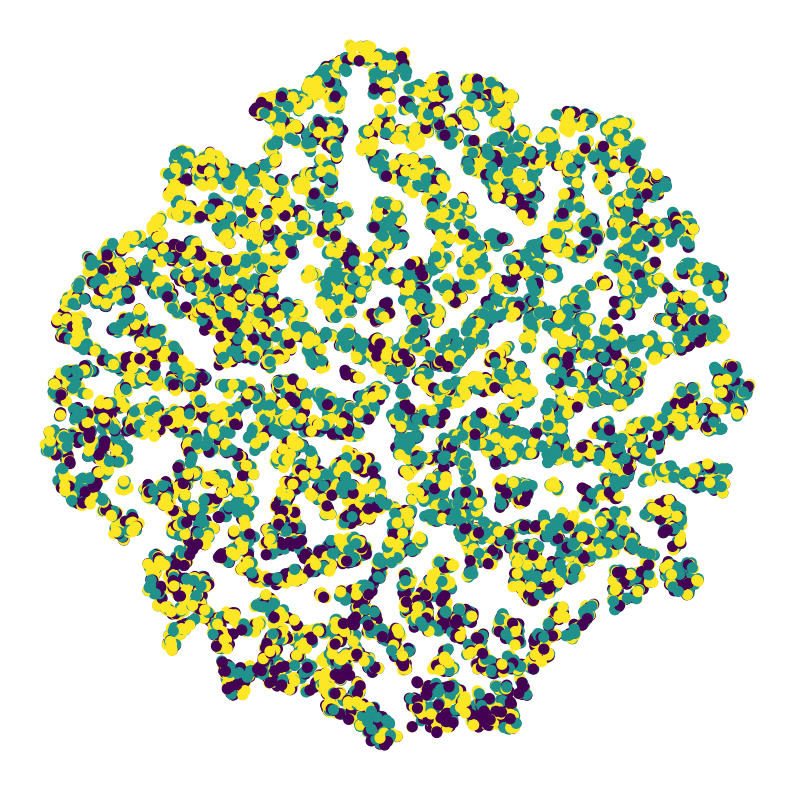

In [167]:
# Initialize new untrained model
untrained_gat = GAT(dataset.num_features, 8, dataset.num_classes)

# Get embeddings
h, _ = untrained_gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

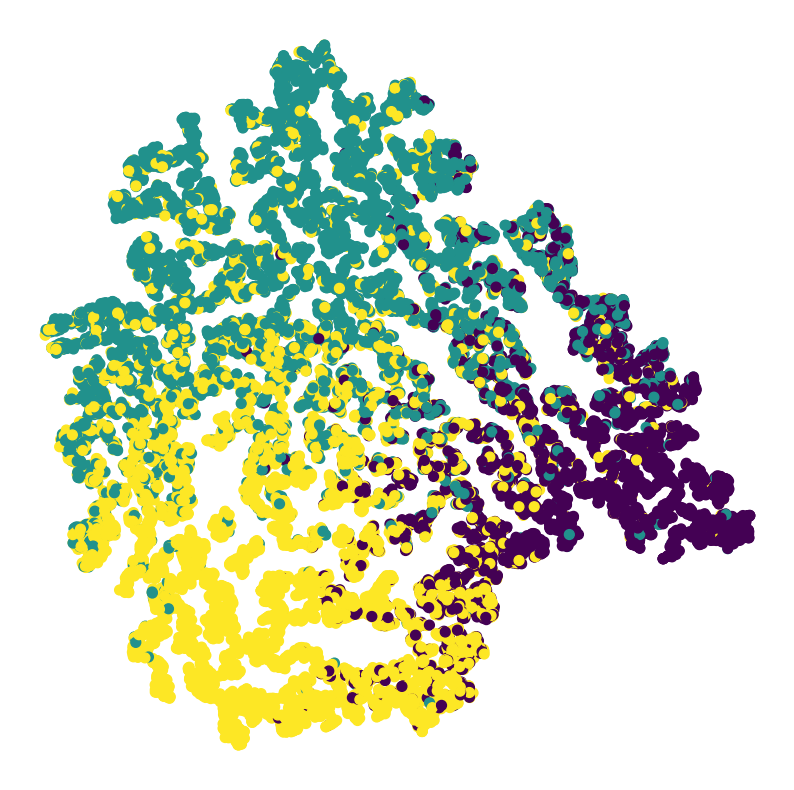

In [ ]:
# Get embeddings
h, _ = gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()